In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
DATADIR = r"C:\Users\user\Face-Mask-Detection-master\dataset"
DATATYPE = ["with_mask","without_mask"]

print("loading images")

data = []
labels = []

loading images


In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

for dtype in DATATYPE:
    path = os.path.join(DATADIR,dtype)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(dtype)

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
#one hot encoding
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(data, labels, test_size=0.2, stratify = labels , random_state = 42)

In [7]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# image generator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range = 20,
                        zoom_range = 0.15,
                        width_shift_range = 0.2,
                        height_shift_range = 0.2,
                        shear_range = 0.15,
                        horizontal_flip = True,
                        fill_mode = "nearest")

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

BaseModel = MobileNetV2(weights='imagenet', include_top=False,
                       input_tensor = Input(shape=(224,224,3)))

In [9]:
# fully connected layer
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

headModel = BaseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [10]:
#actual model
from tensorflow.keras.models import Model

model = Model(inputs=BaseModel.input, outputs=headModel)

In [11]:
for layer in BaseModel.layers:
    layer.trainable = False

In [12]:
#compile the model
from tensorflow.keras.optimizers.legacy import Adam

opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

C:\Users\user\anaconda3\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# training

H = model.fit(aug.flow(Xtrain,Ytrain, batch_size=BS),
             steps_per_epoch=len(Xtrain) // BS,
             validation_data=(Xtest, Ytest),
             validation_steps=len(Xtest) // BS,
             epochs = EPOCHS)

Epoch 1/20
95/95 [==============================] - 89s 901ms/step - loss: 0.3922 - accuracy: 0.8507 - val_loss: 0.1469 - val_accuracy: 0.9804
Epoch 2/20
95/95 [==============================] - 81s 848ms/step - loss: 0.1483 - accuracy: 0.9588 - val_loss: 0.0827 - val_accuracy: 0.9857
Epoch 3/20
95/95 [==============================] - 80s 840ms/step - loss: 0.1032 - accuracy: 0.9690 - val_loss: 0.0649 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 81s 849ms/step - loss: 0.0836 - accuracy: 0.9779 - val_loss: 0.0513 - val_accuracy: 0.9870
Epoch 5/20
95/95 [==============================] - 78s 822ms/step - loss: 0.0696 - accuracy: 0.9782 - val_loss: 0.0449 - val_accuracy: 0.9870
Epoch 6/20
95/95 [==============================] - 79s 829ms/step - loss: 0.0577 - accuracy: 0.9842 - val_loss: 0.0425 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 79s 833ms/step - loss: 0.0580 - accuracy: 0.9845 - val_loss: 0.0415 - val_accuracy: 0.9922

In [14]:
predIDXS = model.predict(Xtest, batch_size = BS)

24/24 [==============================] - 16s 632ms/step


In [15]:
predIDXS = np.argmax(predIDXS, axis=1)

In [16]:
# evaluation

from sklearn.metrics import classification_report

print(classification_report(Ytest.argmax(axis=1), predIDXS, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [18]:
model.save("Face_Mask_detector.model", save_format="h5")

C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


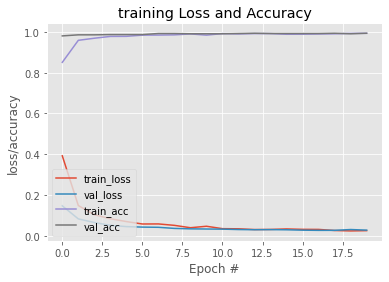

In [19]:
import matplotlib.pyplot as plt

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("loss/accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")